In [92]:
import numpy as np
import pandas as pd
import catboost as ctb
import lightgbm as lgb
import pickle
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [52]:
data = pd.read_csv('data_set .csv')
data.head()

,site_id,appsflyer_id,publisher,sub_site_id,date,app_id,app_version,attributed_touch_time,attributed_touch_type,operator,...,contributor_1_touch_time,contributor_2_publisher,contributor_2_touch_time,contributor_3_publisher,contributor_3_touch_time,install_time,language,os_version,sdk_version,wifi
0,0,148552020,AA,0,2017-10-17,id966165025,3006005000,2017-10-17 21:20:31,click,NaN,...,2017-10-17 16:57:04,AA,0000-00-00 00:00:00,AA,0000-00-00 00:00:00,2017-10-17 21:23:30,en-GB,10.3.3,v4.8.0,0
1,2588,6912501,AA,1133,2017-10-08,ng.jiji.app,3004002000,2017-10-08 17:46:52,click,MTN NG,...,2017-10-08 17:46:50,AA,2017-10-08 17:34:34,AA,0000-00-00 00:00:00,2017-10-08 17:47:02,English,7.0,v4.8.3,0
2,2588,142889582,AA,1813,2017-10-06,ng.jiji.app,3004002000,2017-10-06 11:00:39,click,MTN - NG,...,2017-10-06 10:58:32,AA,2017-10-01 17:24:03,AA,0000-00-00 00:00:00,2017-10-06 11:00:57,English,5.1,v4.8.3,0
3,2588,491337173,AA,1813,2017-10-06,ng.jiji.app,3004002000,2017-10-06 13:38:31,click,Airtel,...,2017-10-06 13:38:15,AA,0000-00-00 00:00:00,AA,0000-00-00 00:00:00,2017-10-06 13:38:55,français,4.4.2,v4.8.3,0
4,2588,156920862,AA,1813,2017-10-06,ng.jiji.app,3004002000,2017-10-06 13:59:55,click,MTN NG,...,2017-09-30 20:17:37,AA,0000-00-00 00:00:00,AA,0000-00-00 00:00:00,2017-10-06 14:29:37,English,6.0,v4.8.3,0


In [53]:
labels = pd.read_csv('labels.csv', sep=';')
labels.head()

,Appsflyer_id,App_id,Publisher (media_source),Site_id,Fraud_reasons
0,740548623,ng.jiji.app,BR,4601,bots
1,151985749,ng.jiji.app,BN,1545,click_spamming
2,70156806,ng.jiji.app,BR,4601,bots
3,270410139,ng.jiji.app,BR,4601,bots
4,123443599,ng.jiji.app,BN,1838,tti_fraud


In [54]:
data = data.merge(labels, how='left', left_on='appsflyer_id', right_on='Appsflyer_id')
data.head()

,site_id,appsflyer_id,publisher,sub_site_id,date,app_id,app_version,attributed_touch_time,attributed_touch_type,operator,...,install_time,language,os_version,sdk_version,wifi,Appsflyer_id,App_id,Publisher (media_source),Site_id,Fraud_reasons
0,0,148552020,AA,0,2017-10-17,id966165025,3006005000,2017-10-17 21:20:31,click,NaN,...,2017-10-17 21:23:30,en-GB,10.3.3,v4.8.0,0,NaN,NaN,NaN,NaN,NaN
1,2588,6912501,AA,1133,2017-10-08,ng.jiji.app,3004002000,2017-10-08 17:46:52,click,MTN NG,...,2017-10-08 17:47:02,English,7.0,v4.8.3,0,NaN,NaN,NaN,NaN,NaN
2,2588,142889582,AA,1813,2017-10-06,ng.jiji.app,3004002000,2017-10-06 11:00:39,click,MTN - NG,...,2017-10-06 11:00:57,English,5.1,v4.8.3,0,NaN,NaN,NaN,NaN,NaN
3,2588,491337173,AA,1813,2017-10-06,ng.jiji.app,3004002000,2017-10-06 13:38:31,click,Airtel,...,2017-10-06 13:38:55,français,4.4.2,v4.8.3,0,NaN,NaN,NaN,NaN,NaN
4,2588,156920862,AA,1813,2017-10-06,ng.jiji.app,3004002000,2017-10-06 13:59:55,click,MTN NG,...,2017-10-06 14:29:37,English,6.0,v4.8.3,0,NaN,NaN,NaN,NaN,NaN


In [55]:
data_train, data_valid = train_test_split(data, test_size=0.2, random_state=42)

In [56]:
data_train.shape

(369200, 29)

In [57]:
data_valid.shape

(92300, 29)

In [58]:
def print_metrics(model, x_valid, y_valid, le):
    y_pred = model.predict(x_valid)

    accuracy = accuracy_score(y_valid, y_pred)
    precisions = precision_score(le.inverse_transform(y_valid), le.inverse_transform(y_pred), average=None,
                                 labels=le.classes_)
    recalls = recall_score(le.inverse_transform(y_valid), le.inverse_transform(y_pred), average=None,
                           labels=le.classes_)
    print(f'Overall accuracy: {100 * accuracy:.2f}%')
    for i in range(len(le.classes_)):
        print(f'Fraud reason: {le.classes_[i]}, Precision: {(100 * precisions[i]):.2f}%, Recall: {(100 * recalls[i]):.2f}%')

In [59]:
def get_cat_columns(df):
    cat_columns_index = np.where(df.dtypes != float)[0]
    cat_columns = df.columns[cat_columns_index].values
    return cat_columns_index, cat_columns

In [60]:
def encode_cat_features(x_train, x_valid):
    _, cat_columns = get_cat_columns(x_train)
    le_dict = {col: LabelEncoder() for col in cat_columns}
    for col in cat_columns:
        x_train[col] = le_dict[col].fit_transform(x_train[col].astype('str'))
        x_valid[col] = le_dict[col].fit_transform(x_valid[col].astype('str'))
    return x_train, x_valid

In [61]:
def train_catboost(x_train, y_train, x_valid, y_valid, le):
    cat_columns_index, _ = get_cat_columns(x_train)
    catboost_model = ctb.CatBoostClassifier(loss_function='MultiClass', eval_metric='Accuracy', use_best_model=True, random_seed=42)
    catboost_model.fit(x_train, y_train, cat_features=cat_columns_index, eval_set=(x_valid, y_valid))
    pickle.dump(catboost_model, open("catboost.model", "wb"))
    print_metrics(catboost_model, x_valid, y_valid, le)

In [62]:
def train_lgb(x_train, y_train, x_valid, y_valid, le):
    x_train, x_valid = encode_cat_features(x_train, x_valid)
    lgb_model = lgb.LGBMClassifier(objective='multiclass', learning_rate=0.02, n_estimators=400, num_iterations=1000,
                               num_leaves=100, max_depth=7)
    lgb_model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], early_stopping_rounds=10)
    pickle.dump(lgb_model, open('lgb.model', 'wb'))
    lgb_model = pickle.load(open('lgb.model', 'rb'))
    print_metrics(lgb_model, x_valid, y_valid, le)

    fig, ax = plt.subplots(figsize=(12, 18))
    lgb.plot_importance(lgb_model, max_num_features=30, height=0.5, ax=ax)
    plt.savefig('feature_importance_lgb.png', bbox_inches='tight')

In [63]:
data.drop(data[data['Fraud_reasons'] == 'mix'].index, inplace=True)
data_valid.drop(data_valid[data_valid['Fraud_reasons'] == 'mix'].index, inplace=True)
data.loc[data['Fraud_reasons'].isnull(), 'Fraud_reasons'] = 'ok'
data_valid.loc[data_valid['Fraud_reasons'].isnull(), 'Fraud_reasons'] = 'ok'
fraud_reasons = data['Fraud_reasons'].unique()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [64]:
fraud_reasons

array(['ok', 'Data center', 'click_spamming', 'bots', 'tti_fraud'], dtype=object)

In [65]:
data['install_time'] = pd.to_datetime(data['install_time'])
data_valid['install_time'] = pd.to_datetime(data_valid['install_time'])
data['attributed_touch_time'] = pd.to_datetime(data['attributed_touch_time'])
data_valid['attributed_touch_time'] = pd.to_datetime(data_valid['attributed_touch_time'])
data['contributor_1_touch_time'] = pd.to_datetime(data['contributor_1_touch_time'], errors='coerce')
data['contributor_2_touch_time'] = pd.to_datetime(data['contributor_2_touch_time'], errors='coerce')
data['contributor_3_touch_time'] = pd.to_datetime(data['contributor_3_touch_time'], errors='coerce')
data_valid['contributor_1_touch_time'] = pd.to_datetime(data_valid['contributor_1_touch_time'], errors='coerce')
data_valid['contributor_2_touch_time'] = pd.to_datetime(data_valid['contributor_2_touch_time'], errors='coerce')
data_valid['contributor_3_touch_time'] = pd.to_datetime(data_valid['contributor_3_touch_time'], errors='coerce')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

In [66]:
data.columns

Index(['site_id', 'appsflyer_id', 'publisher', 'sub_site_id', 'date', 'app_id',
       'app_version', 'attributed_touch_time', 'attributed_touch_type',
       'operator', 'city', 'country_code', 'device_type',
       'contributor_1_publisher', 'contributor_1_touch_time',
       'contributor_2_publisher', 'contributor_2_touch_time',
       'contributor_3_publisher', 'contributor_3_touch_time', 'install_time',
       'language', 'os_version', 'sdk_version', 'wifi', 'Appsflyer_id',
       'App_id', 'Publisher (media_source)', 'Site_id', 'Fraud_reasons'],
      dtype='object')

In [67]:
android_versions = pd.read_csv('android_versions.csv', delimiter=',')
android_versions['release_date'] = pd.to_datetime(android_versions['release_date'])
android_versions['version'] = android_versions['version'].apply(lambda x: int(x.replace('.', '00')))
data = data.merge(android_versions, how='left', left_on='app_version', right_on='version')
data_valid = data_valid.merge(android_versions, how='left', left_on='app_version', right_on='version')

ios_app_id = 'id966165025'
android_app_id = 'ng.jiji.app'
data.loc[data['app_id'] == ios_app_id, 'release_date'] = np.datetime64('NaT')
data_valid.loc[data_valid['app_id'] == ios_app_id, 'release_date'] = np.datetime64('NaT')

In [68]:
extracted_features_columns = np.array([])

def estimate_gaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

def multivariate_gaussian(dataset, mu, sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

def estimate_gaussian_series(series):
    mu = series[~series.isnull()].mean()
    sigma = series[~series.isnull()].std()
    return mu, sigma

def univariate_gaussian(series, mu, sigma):
    p = norm(loc=mu, scale=sigma)
    return p.pdf(series)
    #return norm.rvs(loc=0, scale=1, size=len(series))

def set_time_features(data, data_valid):
    data['install_time_sec'] = (data['install_time'] - pd.datetime.now()).dt.total_seconds()
    data['release_date_sec'] = (data['release_date'] - pd.datetime.now()).dt.total_seconds()

    data_valid['install_time_sec'] = (data_valid['install_time'] - pd.datetime.now()).dt.total_seconds()
    data_valid['release_date_sec'] = (data_valid['release_date'] - pd.datetime.now()).dt.total_seconds()

    data['tti'] = (data['install_time']
                   - data['attributed_touch_time']).dt.total_seconds()
    data_valid['tti'] = (pd.to_datetime(data_valid['install_time'])
                         - data_valid['attributed_touch_time']).dt.total_seconds()

    data['time_diff_contributor1'] = (data['attributed_touch_time']
                                      - data['contributor_1_touch_time']).dt.total_seconds()
    data['time_diff_contributor2'] = (data['contributor_1_touch_time']
                                      - data['contributor_2_touch_time']).dt.total_seconds()
    data['time_diff_contributor3'] = (data['contributor_2_touch_time']
                                      - data['contributor_3_touch_time']).dt.total_seconds()

    data_valid['time_diff_contributor1'] = (data_valid['attributed_touch_time']
                                            - data_valid['contributor_1_touch_time']).dt.total_seconds()
    data_valid['time_diff_contributor2'] = (data_valid['contributor_1_touch_time']
                                            - data_valid['contributor_2_touch_time']).dt.total_seconds()
    data_valid['time_diff_contributor3'] = (data_valid['contributor_2_touch_time']
                                            - data_valid['contributor_3_touch_time']).dt.total_seconds()

    extracted_features_columns = np.array(['tti', 'release_date_sec', 'install_time_sec',
                                          'time_diff_contributor1', 'time_diff_contributor2', 'time_diff_contributor3'])

    return data, data_valid, extracted_features_columns

def set_fraud_rate_feature(train_df, valid_df, column, mean_fraud, fraud_reason):
    rate_feature_column = column + '_' + fraud_reason + '_fraud_rate'
    ratio = train_df[['Fraud_reasons', column]].groupby([column]).agg(
        lambda x: (x['Fraud_reasons'] == fraud_reason).sum()/len(x))
    ratio.rename(columns={'Fraud_reasons': rate_feature_column}, inplace=True)

    train_df = pd.merge(train_df, ratio, how='left', left_on=column, right_index=True)
    train_df[rate_feature_column] = train_df[rate_feature_column].fillna(mean_fraud)
    # train_df[rate_feature_column] = train_df[rate_feature_column].fillna(0)

    valid_df = pd.merge(valid_df, ratio, how='left', left_on=column, right_index=True)
    valid_df[rate_feature_column] = valid_df[rate_feature_column].fillna(mean_fraud)
    # valid_df[rate_feature_column] = valid_df[rate_feature_column].fillna(0)
    return train_df, valid_df, rate_feature_column

fraud_rates_columns = ['language', 'publisher', 'operator', 'device_type',
                       'os_version', 'sdk_version', 'app_id', 'app_version', 'wifi']

data, data_valid, time_features = set_time_features(data, data_valid)
extracted_features_columns = np.concatenate((extracted_features_columns, time_features))

def set_categorical_fetures(data, data_valid):
    data['wifi'] = data['wifi'].astype(str)
    data_valid['wifi'] = data_valid['wifi'].astype(str)
    cat_features = np.array(['language', 'publisher', 'operator', 'device_type',
                             'os_version', 'sdk_version', 'app_id', 'app_version', 'wifi'])

    return data, data_valid, cat_features

data, data_valid, cat_features = set_categorical_fetures(data, data_valid)
extracted_features_columns = np.concatenate((extracted_features_columns, cat_features))

"""
def set_distribution_features(data, data_valid):
    # trustworthy_publisher_marker = data['publisher'].isin(['AX', 'AG'])
    trustworthy_publisher_marker = data['Fraud_reasons'] == 'ok'
    distribution_features = np.array([])
    features = ['tti', 'release_date_sec', 'install_time_sec',
                'time_diff_contributor1', 'time_diff_contributor2', 'time_diff_contributor3']
    fraud_reasons_without_ok = np.array([x for x in fraud_reasons if x != 'ok'])
    for feature in features:
        mu, sigma = estimate_gaussian_series(data.loc[trustworthy_publisher_marker, feature])
        data[feature + '_p_ok'] = univariate_gaussian(data[feature], mu, sigma)
        data_valid[feature + '_p_ok'] = univariate_gaussian(data_valid[feature], mu, sigma)
        distribution_features = np.concatenate((distribution_features, np.array([feature + '_p_ok'])))
        for fraud_reason in fraud_reasons_without_ok:
            mu, sigma = estimate_gaussian_series(data.loc[data['Fraud_reasons'] == fraud_reason, feature])
            data[feature + '_p_' + fraud_reason] = univariate_gaussian(data[feature], mu, sigma)
            data_valid[feature + '_p_' + fraud_reason] = univariate_gaussian(data_valid[feature], mu, sigma)
            distribution_features = np.concatenate((distribution_features, np.array([feature + '_p_' + fraud_reason])))
    return data, data_valid, distribution_features
data, data_valid, distribution_features = set_distribution_features(data, data_valid)
extracted_features_columns = np.concatenate((extracted_features_columns, distribution_features))
"""

extracted_features_columns = np.concatenate((extracted_features_columns, np.array(['Fraud_reasons'])))
extracted_features_train = data[extracted_features_columns]
extracted_features_train.to_csv('extracted_features_train.csv', sep=';', index=False, encoding='utf-8')

extracted_features_valid = data_valid[extracted_features_columns]
extracted_features_valid.to_csv('extracted_features_valid.csv', sep=';', index=False, encoding='utf-8')

In [69]:
from sklearn.preprocessing import LabelEncoder

data_train = pd.read_csv('extracted_features_train.csv', sep=';')
data_valid = pd.read_csv('extracted_features_valid.csv', sep=';')


data_train.drop(data_train[data_train['Fraud_reasons'] == 'mix'].index, inplace=True)
data_valid.drop(data_valid[data_valid['Fraud_reasons'] == 'mix'].index, inplace=True)

data_train.loc[data_train['Fraud_reasons'].isnull(), 'Fraud_reasons'] = 'ok'
data_valid.loc[data_valid['Fraud_reasons'].isnull(), 'Fraud_reasons'] = 'ok'

label_encoder = LabelEncoder()
le = label_encoder.fit(data_train['Fraud_reasons'].values)
y_train = le.transform(data_train['Fraud_reasons'].values)
y_valid = le.transform(data_valid['Fraud_reasons'].values)
x_train = data_train.loc[:, data_train.columns != 'Fraud_reasons']
x_valid = data_valid.loc[:, data_valid.columns != 'Fraud_reasons']
x_valid = x_valid[x_train.columns]

#train_lgb(x_train, y_train, x_valid, y_valid, le)

In [70]:
x_train = x_train.fillna(0)
x_valid = x_valid.fillna(0)

In [71]:
from sklearn import svm

def train_svm(x_train, y_train, x_valid, y_valid, le):
    x_train, x_valid = encode_cat_features(x_train, x_valid)
    clf = svm.SVC(decision_function_shape='ovo')
    clf.fit(x_train, y_train)
    print_metrics(svm, x_valid, y_valid, le)

def train_svm_lin(x_train, y_train, x_valid, y_valid, le):
    x_train, x_valid = encode_cat_features(x_train, x_valid)
    lin_clf = svm.LinearSVC()
    lin_clf.fit(x_train, y_train)
    print_metrics(lin_clf, x_valid, y_valid, le)

In [72]:
#train_svm(x_train, y_train, x_valid, y_valid, le)

In [73]:
#train_svm_lin(x_train, y_train, x_valid, y_valid, le)

In [74]:
from sklearn.neighbors import KNeighborsClassifier

def train_knn(x_train, y_train, x_valid, y_valid, le):
    x_train, x_valid = encode_cat_features(x_train, x_valid)
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(x_train, y_train)     
    print_metrics(neigh, x_valid, y_valid, le)


In [75]:
train_knn(x_train, y_train, x_valid, y_valid, le)

Overall accuracy: 84.71%
Fraud reason: Data center, Precision: 33.33%, Recall: 9.38%
Fraud reason: bots, Precision: 69.24%, Recall: 56.96%
Fraud reason: click_spamming, Precision: 61.10%, Recall: 30.72%
Fraud reason: ok, Precision: 88.16%, Recall: 94.40%
Fraud reason: tti_fraud, Precision: 44.61%, Recall: 25.92%


In [76]:
from sklearn.naive_bayes import BernoulliNB

def train_bayes(x_train, y_train, x_valid, y_valid, le):
    x_train, x_valid = encode_cat_features(x_train, x_valid)
    clf = BernoulliNB()
    clf.fit(x_train, y_train)     
    print_metrics(clf, x_valid, y_valid, le)
    

In [77]:
train_bayes(x_train, y_train, x_valid, y_valid, le)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Overall accuracy: 81.10%
Fraud reason: Data center, Precision: 0.00%, Recall: 0.00%
Fraud reason: bots, Precision: 47.28%, Recall: 62.99%
Fraud reason: click_spamming, Precision: 0.00%, Recall: 0.00%
Fraud reason: ok, Precision: 85.79%, Recall: 92.44%
Fraud reason: tti_fraud, Precision: 0.00%, Recall: 0.00%


In [78]:
from sklearn.ensemble import RandomForestClassifier

def train_rfc(x_train, y_train, x_valid, y_valid, le):
    x_train, x_valid = encode_cat_features(x_train, x_valid)
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf.fit(x_train, y_train)     
    print_metrics(clf, x_valid, y_valid, le)


In [79]:
train_rfc(x_train, y_train, x_valid, y_valid, le)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Overall accuracy: 81.51%
Fraud reason: Data center, Precision: 0.00%, Recall: 0.00%
Fraud reason: bots, Precision: 0.00%, Recall: 0.00%
Fraud reason: click_spamming, Precision: 0.00%, Recall: 0.00%
Fraud reason: ok, Precision: 81.51%, Recall: 100.00%
Fraud reason: tti_fraud, Precision: 0.00%, Recall: 0.00%


In [80]:
from sklearn.ensemble import GradientBoostingClassifier

def train_gbc(x_train, y_train, x_valid, y_valid, le):
    x_train, x_valid = encode_cat_features(x_train, x_valid)
    clf = GradientBoostingClassifier()
    clf.fit(x_train, y_train)     
    print_metrics(clf, x_valid, y_valid, le)

In [81]:
train_gbc(x_train, y_train, x_valid, y_valid, le)

Overall accuracy: 85.12%
Fraud reason: Data center, Precision: 92.31%, Recall: 37.50%
Fraud reason: bots, Precision: 81.43%, Recall: 31.26%
Fraud reason: click_spamming, Precision: 0.00%, Recall: 0.00%
Fraud reason: ok, Precision: 85.76%, Recall: 98.08%
Fraud reason: tti_fraud, Precision: 71.15%, Recall: 35.71%


In [82]:
from sklearn.tree import DecisionTreeClassifier

def train_dtc(x_train, y_train, x_valid, y_valid, le):
    x_train, x_valid = encode_cat_features(x_train, x_valid)
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(x_train, y_train)     
    print_metrics(clf, x_valid, y_valid, le)

In [83]:
train_dtc(x_train, y_train, x_valid, y_valid, le)

Overall accuracy: 79.12%
Fraud reason: Data center, Precision: 0.00%, Recall: 0.00%
Fraud reason: bots, Precision: 13.14%, Recall: 3.61%
Fraud reason: click_spamming, Precision: 4.68%, Recall: 4.78%
Fraud reason: ok, Precision: 83.71%, Recall: 93.28%
Fraud reason: tti_fraud, Precision: 70.10%, Recall: 40.44%


In [86]:
from sklearn.linear_model import LogisticRegression

def train_log(x_train, y_train, x_valid, y_valid, le):
    x_train, x_valid = encode_cat_features(x_train, x_valid)
    clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')
    clf.fit(x_train, y_train)     
    print_metrics(clf, x_valid, y_valid, le)

In [87]:
train_log(x_train, y_train, x_valid, y_valid, le)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Overall accuracy: 81.39%
Fraud reason: Data center, Precision: 0.00%, Recall: 0.00%
Fraud reason: bots, Precision: 0.00%, Recall: 0.00%
Fraud reason: click_spamming, Precision: 24.32%, Recall: 1.90%
Fraud reason: ok, Precision: 81.52%, Recall: 99.79%
Fraud reason: tti_fraud, Precision: 0.00%, Recall: 0.00%


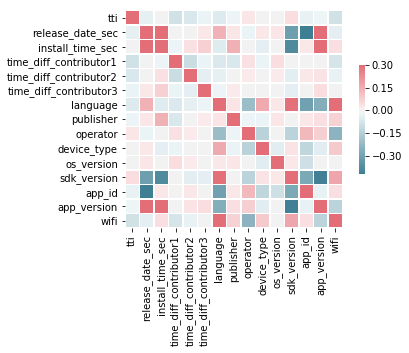

In [93]:
corr = x_train.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})